In [2]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q transformers biopython kaggle
print("✅ Đã cài đặt xong thư viện!")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 89.9 MB/s eta 0:00:00
✅ Đã cài đặt xong thư viện!


In [3]:
import os
from google.colab import files

# Upload file kaggle.json
print("Vui lòng upload file kaggle.json của bạn:")
files.upload()

# Cấu hình Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Tải dữ liệu cuộc thi (Sẽ mất khoảng 1-2 phút)
print("⏳ Đang tải dữ liệu CAFA 6...")
!kaggle competitions download -c cafa-6-protein-function-prediction
!unzip -q cafa-6-protein-function-prediction.zip -d /content/cafa6_data
print("✅ Đã tải và giải nén dữ liệu tại /content/cafa6_data")

Vui lòng upload file kaggle.json của bạn:


Saving kaggle.json to kaggle.json
⏳ Đang tải dữ liệu CAFA 6...
  0% 0.00/91.3M [00:00<?, ?B/s]
100% 91.3M/91.3M [00:00<00:00, 1.52GB/s]
✅ Đã tải và giải nén dữ liệu tại /content/cafa6_data


In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import gc
import os
import sys
from tqdm.auto import tqdm

# ============================================================================
# CONFIGURATION
# ============================================================================
CONFIG = {
    'EMBEDDINGS': {
        'ankh': {
            'train': '/content/drive/MyDrive/CAFA6_Embeddings/Final_Merged/ankh_train_FINAL_embeddings.npy',
            'test':  '/content/drive/MyDrive/CAFA6_Embeddings/Final_Merged/ankh_test_FINAL_embeddings.npy',
        },
        'esm': {
            'train': '/content/drive/MyDrive/CAFA6_Embeddings/ESM2_Aligned_Ankh/esm2_train_FINAL_embeddings.npy',
            'test':  '/content/drive/MyDrive/CAFA6_Embeddings/ESM2_Aligned_Ankh/esm2_test_FINAL_embeddings.npy',
        },
        'prot_t5': {
            'train': '/content/drive/MyDrive/CAFA6_Embeddings/Prot_T5_Aligned/protT5_xl_train_FINAL_embeddings.npy',
            'test':  '/content/drive/MyDrive/CAFA6_Embeddings/Prot_T5_Aligned/protT5_xl_test_FINAL_embeddings.npy',
        },
        # 'protBERT': {
        #     'train': '/content/drive/MyDrive/CAFA6_Embeddings/protBERT_Aligned/protBERT_train_FINAL_embeddings.npy',
        #     'test':  '/content/drive/MyDrive/CAFA6_Embeddings/protBERT_Aligned/protBERT_test_FINAL_embeddings.npy',
        # },
    },

    'TRAIN_ID_PATH': '/content/drive/MyDrive/CAFA6_Embeddings/Final_Merged/ankh_train_FINAL_ids.npy',
    'TEST_ID_PATH':  '/content/drive/MyDrive/CAFA6_Embeddings/Final_Merged/ankh_test_FINAL_ids.npy',

    'SAVE_DIR': '/content/drive/MyDrive/CAFA6_Results/prott5_esm2_ankh_ASL_Run',
    'TRAIN_TERMS': '/content/cafa6_data/Train/train_terms.tsv',
    'IA_FILE': '/content/cafa6_data/IA.tsv',
    'TEST_FASTA': '/content/cafa6_data/Test/testsuperset.fasta',

    # Model Params
    'TOP_K_LABELS': 10000, # Giữ mức này để model học tốt
    # 'MIN_FREQ': 3,

    'ENCODER_LAYERS': [2048, 1024, 512],

    'DROPOUT_RATE': 0.5, # Tăng dropout vì input lớn
    'EPOCHS': 50,
    'BATCH_SIZE': 128,
    'LEARNING_RATE': 2e-4, # Giảm LR một chút cho ổn định
    'LABEL_SMOOTHING': 0.0,
    'WEIGHT_DECAY': 0.05,

    # Inference Params (Chuẩn 0.27 điểm)
    'MIN_CONFIDENCE': 0.4,
    'MAX_PREDS_PER_PROTEIN': 25,

    'SEED': 42,
    'DEVICE': 'cuda' if torch.cuda.is_available() else 'cpu'
}

os.makedirs(CONFIG['SAVE_DIR'], exist_ok=True)
print(f"🚀 CAFA 6 - DUAL MODEL (ANKH + ESM) | Device: {CONFIG['DEVICE']}")

torch.manual_seed(CONFIG['SEED'])
np.random.seed(CONFIG['SEED'])

# ============================================================================
# 1. MEMORY-SAFE DATASET (CHÌA KHÓA ĐỂ KHÔNG TRÀN RAM)
# ============================================================================
class MultiSourceDataset(Dataset):
    def __init__(self, embedding_paths_dict, y_tensor=None, indices=None):
        self.mmaps = {}
        self.keys = list(embedding_paths_dict.keys())

        # Load mmap
        for name, path in embedding_paths_dict.items():
            self.mmaps[name] = np.load(path, mmap_mode='r')

        # Base length
        first_key = self.keys[0]
        self.total_len = len(self.mmaps[first_key])

        self.indices = indices if indices is not None else np.arange(self.total_len)
        self.y = y_tensor

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]

        inputs = []
        # Load từng vector -> List of Tensors
        for key in self.keys:
            vec = torch.from_numpy(self.mmaps[key][real_idx].copy()).float()
            inputs.append(vec)

        if self.y is not None:
            return inputs, self.y[real_idx]
        return (inputs,)

# ============================================================================
# 2. LOAD DATA & PROCESS LABELS
# ============================================================================
print("\n[1/5] Checking Files...")
train_ids = np.load(CONFIG['TRAIN_ID_PATH'])
print(f"   ✓ Train IDs: {len(train_ids)}")

print("\n[2/5] Processing Labels (IA Strategy)...")
# 1. Load Terms & IA
df_terms = pd.read_csv(CONFIG['TRAIN_TERMS'], sep='\t', header=0, names=['EntryID', 'term', 'aspect'])
df_ia = pd.read_csv(CONFIG['IA_FILE'], sep='\t', names=['term', 'ia'])
ia_dict = dict(zip(df_ia['term'], df_ia['ia']))

# 2. Tính Score
term_counts = df_terms['term'].value_counts().reset_index()
term_counts.columns = ['term', 'freq']

# print(f"   Original terms count: {len(term_counts)}")
# term_counts = term_counts[term_counts['freq'] >= CONFIG['MIN_FREQ']]
# print(f"   -> After filtering (Freq >= {CONFIG['MIN_FREQ']}): {len(term_counts)} terms")

term_counts['ia'] = term_counts['term'].map(ia_dict).fillna(0.0)
term_counts['score'] = term_counts['freq'] * term_counts['ia']

# 3. Chọn Top K
top_terms_df = term_counts.sort_values(by='score', ascending=False).head(CONFIG['TOP_K_LABELS'])
top_terms = top_terms_df['term'].tolist()
print(f"   ✓ Selected {len(top_terms)} terms.")

# 4. Map ID -> Terms
df_filtered = df_terms[df_terms['term'].isin(top_terms)]
id_to_terms = df_filtered.groupby('EntryID')['term'].apply(list).to_dict()

# Dọn dẹp
del df_terms, df_filtered, df_ia, term_counts, top_terms_df
gc.collect()

# ============================================================================
# 3. PREPARE LABELS (RAM OPTIMIZED)
# ============================================================================
print("\n[3/5] Preparing Labels (Sparse Mode)...")

# 1. Sparse MLB
mlb = MultiLabelBinarizer(classes=top_terms, sparse_output=True)
mlb.fit([top_terms])

# 2. Transform -> Sparse Matrix
y_labels_list = [id_to_terms.get(pid, []) for pid in train_ids]
y_train_sparse = mlb.transform(y_labels_list)
del y_labels_list, train_ids # Xóa ID list không dùng nữa
gc.collect()

# 3. Weights (Optional)
# Nếu dùng IA weight thì giữ, nếu muốn model tự học thì comment dòng này và bỏ pos_weight trong Loss
weights_list = [ia_dict.get(t, 0.0) for t in mlb.classes_]
pos_weight_tensor = torch.tensor(weights_list, dtype=torch.float32).to(CONFIG['DEVICE'])

# 4. Convert to Dense Float32 & Label Smoothing
print("   ⏳ Converting Labels to Tensor...")
# Convert từng phần nhỏ hoặc convert hết nếu RAM > 12GB (với 80k row x 10k col float32 ~ 3.2GB -> Ổn)
y_train_binary = y_train_sparse.astype(np.float32).toarray()
y_train_tensor = torch.from_numpy(y_train_binary)

if CONFIG['LABEL_SMOOTHING'] > 0:
    y_train_tensor.mul_(1 - CONFIG['LABEL_SMOOTHING']).add_(CONFIG['LABEL_SMOOTHING'] / len(top_terms))

del y_train_sparse, y_train_binary
gc.collect()

# ============================================================================
# 4. CREATE DATA LOADERS
# ============================================================================
print("\n[4/5] Creating DataLoaders...")

train_paths = {k: v['train'] for k, v in CONFIG['EMBEDDINGS'].items()}

indices = np.arange(len(y_train_tensor))
train_idx, val_idx = train_test_split(indices, test_size=0.15, random_state=CONFIG['SEED'])

train_dataset = MultiSourceDataset(train_paths, y_train_tensor, indices=train_idx)
val_dataset   = MultiSourceDataset(train_paths, y_train_tensor, indices=val_idx)

# --- AUTO DETECT INPUT DIMS ---
print("   ⏳ Measuring input shapes from dataset...")
sample_inputs, _ = train_dataset[0]
INPUT_DIMS_LIST = [x.shape[0] for x in sample_inputs]
print(f"   ✓ Detected Input Dims: {INPUT_DIMS_LIST}")

train_loader = DataLoader(train_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=2)

# ============================================================================
# 5. MODEL & TRAINING
# ============================================================================
print("\n[5/5] Building Model...")

class EncoderBlock(nn.Module):
    def __init__(self, in_dim, layers_config, dropout):
        super().__init__()
        layers = []

        # 1. LAYER NORM ĐẦU VÀO (BẮT BUỘC)
        # Để cân bằng 'âm lượng' giữa ESM (hét to) và Ankh (nói nhỏ)
        layers.append(nn.LayerNorm(in_dim))

        prev_dim = in_dim
        for i, dim in enumerate(layers_config):
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.BatchNorm1d(dim), # Ổn định training
                nn.GELU(),           # Hiện đại hơn ReLU
                nn.Dropout(dropout)
            ])
            prev_dim = dim

        self.net = nn.Sequential(*layers)
        self.out_dim = prev_dim

    def forward(self, x):
        return self.net(x)

# Module lọc nhiễu (Attention)
class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block để lọc nhiễu sau khi gộp"""
    def __init__(self, in_dim, reduction=4):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_dim, in_dim // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(in_dim // reduction, in_dim, bias=False),
            nn.Sigmoid() # Tạo ra mask từ 0 đến 1
        )

    def forward(self, x):
        # x shape: [Batch, Dim]
        # Attention weight: [Batch, Dim]
        w = self.fc(x)
        # Nhân trọng số vào x: Cái nào quan trọng thì giữ, rác thì nhân với 0
        return x * w

class MultiModalNet(nn.Module):
    def __init__(self, input_dims_list, encoder_layers, dropout, num_classes):
        super().__init__()

        self.encoders = nn.ModuleList()
        self.fusion_input_dim = 0

        print("\n🏗️ Building Advanced Architecture:")

        # 1. Xây dựng các nhánh Encoder
        for i, in_dim in enumerate(input_dims_list):
            print(f"   ➤ Branch {i+1}: Input {in_dim} -> Output {encoder_layers[-1]}")
            enc = EncoderBlock(in_dim, encoder_layers, dropout)
            self.encoders.append(enc)
            self.fusion_input_dim += enc.out_dim

        print(f"   ➤ Fusion Dim: {self.fusion_input_dim}")

        # 2. SE-Block (Bộ lọc thông minh)
        self.attention_filter = SEBlock(self.fusion_input_dim)

        # 3. Layer tổng hợp cuối cùng
        self.head = nn.Sequential(
            nn.BatchNorm1d(self.fusion_input_dim),
            nn.Linear(self.fusion_input_dim, 512),
            nn.GELU(),
            nn.Dropout(dropout),

            # Thêm một lớp nữa để tăng khả năng học
            nn.Linear(512, 512),
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(512, num_classes)
        )

    def forward(self, inputs_list):
        features = []
        # Đi qua từng nhánh
        for i, encoder in enumerate(self.encoders):
            feat = encoder(inputs_list[i])
            features.append(feat)

        # Gộp lại (Concatenate)
        combined = torch.cat(features, dim=1)

        # LỌC NHIỄU (Điểm khác biệt lớn nhất)
        # Mạng sẽ tự học cách "tắt tiếng" các đặc trưng rác từ ProtT5 nếu nó thấy không cần thiết
        refined = self.attention_filter(combined)

        return self.head(refined)

model = MultiModalNet(
    input_dims_list = INPUT_DIMS_LIST,
    encoder_layers  = CONFIG['ENCODER_LAYERS'],
    dropout         = CONFIG['DROPOUT_RATE'],
    num_classes     = len(top_terms) # Dùng số lượng thực tế sau lọc
).to(CONFIG['DEVICE'])

class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False, pos_weight=None):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        self.pos_weight = pos_weight
        if self.pos_weight is not None:
             if not isinstance(self.pos_weight, torch.Tensor):
                 self.pos_weight = torch.tensor(self.pos_weight)
             self.pos_weight = self.pos_weight.view(-1)
             self.register_buffer('weight_buffer', self.pos_weight)
        else:
            self.weight_buffer = None

        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        pos_log = torch.log(self.xs_pos.clamp(min=self.eps))
        if self.weight_buffer is not None:
            pos_log = pos_log.mul(self.weight_buffer)

        # Basic CE calculation
        self.loss = self.targets * pos_log
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            self.loss *= self.asymmetric_w

        return -self.loss.sum() / x.size(0)

# Loss & Optimizer
# Có thể thử bỏ pos_weight nếu thấy loss dao động quá mạnh
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
criterion = AsymmetricLossOptimized(
    gamma_neg=6,    # Phạt nặng mẫu âm dễ
    gamma_pos=0,    # Giữ nguyên mẫu dương
    clip=0.05,      # Cắt bỏ xác suất < 5%
    disable_torch_grad_focal_loss=True,
    pos_weight=pos_weight_tensor
)
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['LEARNING_RATE'], weight_decay=CONFIG['WEIGHT_DECAY'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print(f"\n🚀 START TRAINING ({CONFIG['EPOCHS']} Epochs)...")
best_val_loss = float('inf')
best_model_path = f"{CONFIG['SAVE_DIR']}/prott5_esm2_ankh_best.pth"

# for epoch in range(CONFIG['EPOCHS']):
#     model.train()
#     train_loss = 0
#     for X_b, y_b in train_loader:
#         X_b, y_b = [x.to(CONFIG['DEVICE']) for x in X_b], y_b.to(CONFIG['DEVICE'])
#         optimizer.zero_grad()
#         logits = model(X_b)
#         loss = criterion(logits, y_b)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()
#         train_loss += loss.item()

#     avg_train = train_loss / len(train_loader)

#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for X_b, y_b in val_loader:
#             X_b, y_b = [x.to(CONFIG['DEVICE']) for x in X_b], y_b.to(CONFIG['DEVICE'])
#             logits = model(X_b)
#             loss = criterion(logits, y_b)
#             val_loss += loss.item()

#     avg_val = val_loss / len(val_loader)
#     scheduler.step(avg_val)

#     print(f"Epoch {epoch+1:02d} | Train: {avg_train:.4f} | Val: {avg_val:.4f} | LR: {optimizer.param_groups[0]['lr']:.1e}")

#     if avg_val < best_val_loss:
#         best_val_loss = avg_val
#         torch.save(model.state_dict(), best_model_path)
#         print("  ⭐ New Best Model!")

# ============================================================================
# 6. INFERENCE (STREAMING)
# ============================================================================
print("\n🔮 PREDICTING...")

# Dọn dẹp Training
del train_loader, val_loader, train_dataset, val_dataset, y_train_tensor, optimizer
gc.collect()
torch.cuda.empty_cache()

model.load_state_dict(torch.load(best_model_path))
model.eval()

# Load Test IDs & Paths
test_paths = {k: v['test'] for k, v in CONFIG['EMBEDDINGS'].items()}
test_ids = np.load(CONFIG['TEST_ID_PATH'])

# Test Dataset (Dual Memmap)
test_dataset = MultiSourceDataset(test_paths)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['BATCH_SIZE']*2, shuffle=False, num_workers=2)

submission_path = f"{CONFIG['SAVE_DIR']}/submission.tsv"
n_predictions = 0

with open(submission_path, 'w') as f:
    current_idx = 0
    with torch.no_grad():
        for (X_b,) in tqdm(test_loader, desc="Inference"):
            X_b = [x.to(CONFIG['DEVICE']) for x in X_b]
            logits = model(X_b)
            probs_batch = torch.sigmoid(logits).cpu().numpy()

            ids_batch = test_ids[current_idx : current_idx + len(probs_batch)]
            current_idx += len(probs_batch)

            for i, pid in enumerate(ids_batch):
                probs = probs_batch[i]

                # TOP-K CỨNG (Chiến thuật 0.27 điểm)
                top_k = CONFIG['MAX_PREDS_PER_PROTEIN']
                ind = np.argpartition(probs, -top_k)[-top_k:]
                ind = ind[np.argsort(probs[ind])][::-1]

                for idx in ind:
                    score = probs[idx]
                    if score > CONFIG['MIN_CONFIDENCE']:
                        f.write(f"{pid}\t{top_terms[idx]}\t{score:.3f}\n")
                        n_predictions += 1

            del probs_batch, X_b, logits

print(f"\n✅ DONE! File: {submission_path}")
print(f"\n✅ DONE! Predictions: {n_predictions:,}")

🚀 CAFA 6 - DUAL MODEL (ANKH + ESM) | Device: cuda

[1/5] Checking Files...


KeyboardInterrupt: 

In [ ]:
# Chạy lệnh này trong một cell mới
!kaggle competitions submit \
    -c cafa-6-protein-function-prediction \
    -f /content/drive/MyDrive/CAFA6_Results/prott5_esm2_ankh_ASL_Run/submission.tsv \
    -m "esm2 ankh prot t5 "

100% 128M/128M [00:07<00:00, 17.6MB/s]
Successfully submitted to CAFA 6 Protein Function Prediction

In [ ]:
!kaggle competitions submissions -c cafa-6-protein-function-prediction

fileName        date                        description                                                                              status                     publicScore  privateScore  
--------------  --------------------------  ---------------------------------------------------------------------------------------  -------------------------  -----------  ------------  
submission.tsv  2025-12-10 10:36:17.547000  esm2 ankh prot t5 ASL max_pred=25 MIN_CONFIDENCE=0.4 gamma_pos=0 gamma_neg=6 pos_weight  SubmissionStatus.COMPLETE  0.256                      
submission.tsv  2025-12-10 10:22:41.780000  esm2 ankh prot t5 ASL max_pred=25 MIN_CONFIDENCE=0.4 gamma_pos=0 gamma_neg=6 pos_weight  SubmissionStatus.PENDING                              
submission.tsv  2025-12-09 15:09:25.463000  esm2 ankh prot t5 ASL max_pred=25 MIN_CONFIDENCE=0.2                                     SubmissionStatus.COMPLETE  0.289                      
submission.tsv  2025-12-09 08:42:39.253000  esm2 ankh prot t

In [ ]:
import torch
import torch.nn as nn

# logits = torch.tensor([[0.0, 2.0, -1.0],
#                        [3.0, -2.0, 0.5]])
# targets = torch.tensor([[0., 1., 0.],
#                         [1., 0., 1.]])

logits = torch.tensor([[0.0, 2.0, -1.0]])
targets = torch.tensor([[0., 1., 0.]])

loss_mean = nn.BCEWithLogitsLoss(reduction='mean')(logits, targets)
loss_sum  = nn.BCEWithLogitsLoss(reduction='sum')(logits, targets)

print("mean =", loss_mean.item())  # 0.2970
print("sum  =", loss_sum.item())   # 1.7822


mean = 0.3777790069580078
sum  = 1.1333370208740234


⏳ Đang đọc file submission (Có thể tốn RAM nếu file lớn)...
✅ Đã tải 5,607,619 dòng dự đoán.

📊 PHÂN TÍCH 1: PHÂN PHỐI ĐIỂM SỐ (CONFIDENCE)
count    5.607619e+06
mean     6.724749e-01
std      9.501772e-02
min      3.000000e-01
10%      5.620000e-01
20%      5.970000e-01
30%      6.230000e-01
40%      6.450000e-01
50%      6.660000e-01
60%      6.890000e-01
70%      7.140000e-01
80%      7.470000e-01
90%      7.960000e-01
95%      8.400000e-01
max      9.990000e-01
Name: score, dtype: float64


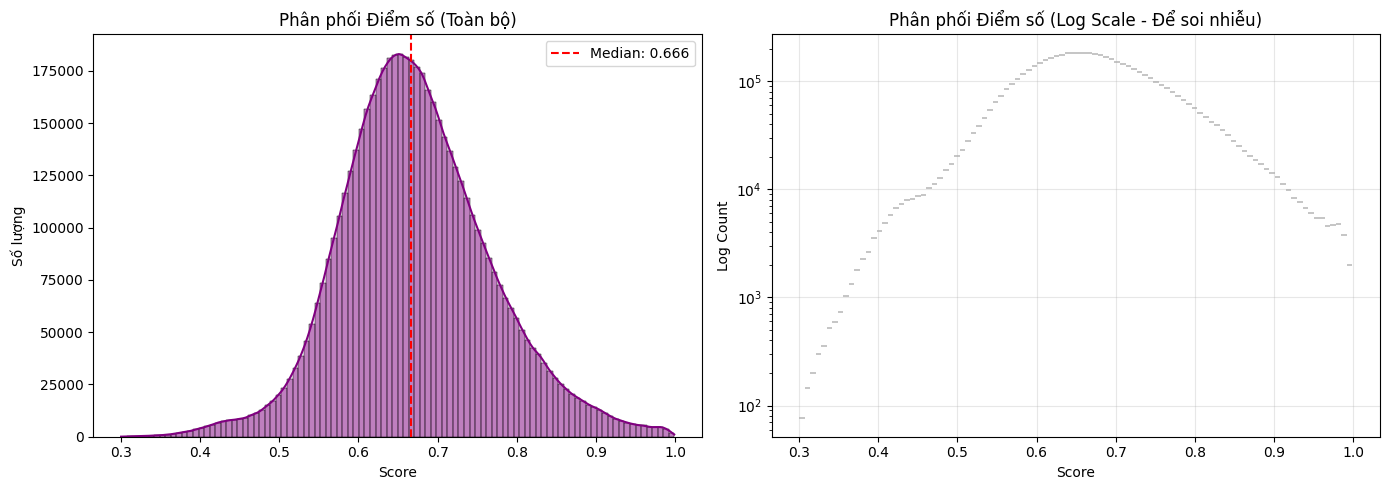


🎯 PHÂN TÍCH 2: GIẢ LẬP SỐ LƯỢNG NHÃN (TOP-K)
Nếu chọn Threshold X, thì trung bình mỗi Protein giữ lại bao nhiêu nhãn?

🔹 Với Threshold >= 0.2:
   - Số protein còn lại: 224,309
   - Trung bình nhãn/protein: 25.0
   - 95% protein có ít hơn: 25 nhãn
   - Max nhãn/protein: 25

🔹 Với Threshold >= 0.3:
   - Số protein còn lại: 224,309
   - Trung bình nhãn/protein: 25.0
   - 95% protein có ít hơn: 25 nhãn
   - Max nhãn/protein: 25

🔹 Với Threshold >= 0.4:
   - Số protein còn lại: 224,309
   - Trung bình nhãn/protein: 24.9
   - 95% protein có ít hơn: 25 nhãn
   - Max nhãn/protein: 25

🔹 Với Threshold >= 0.5:
   - Số protein còn lại: 224,309
   - Trung bình nhãn/protein: 24.3
   - 95% protein có ít hơn: 25 nhãn
   - Max nhãn/protein: 25


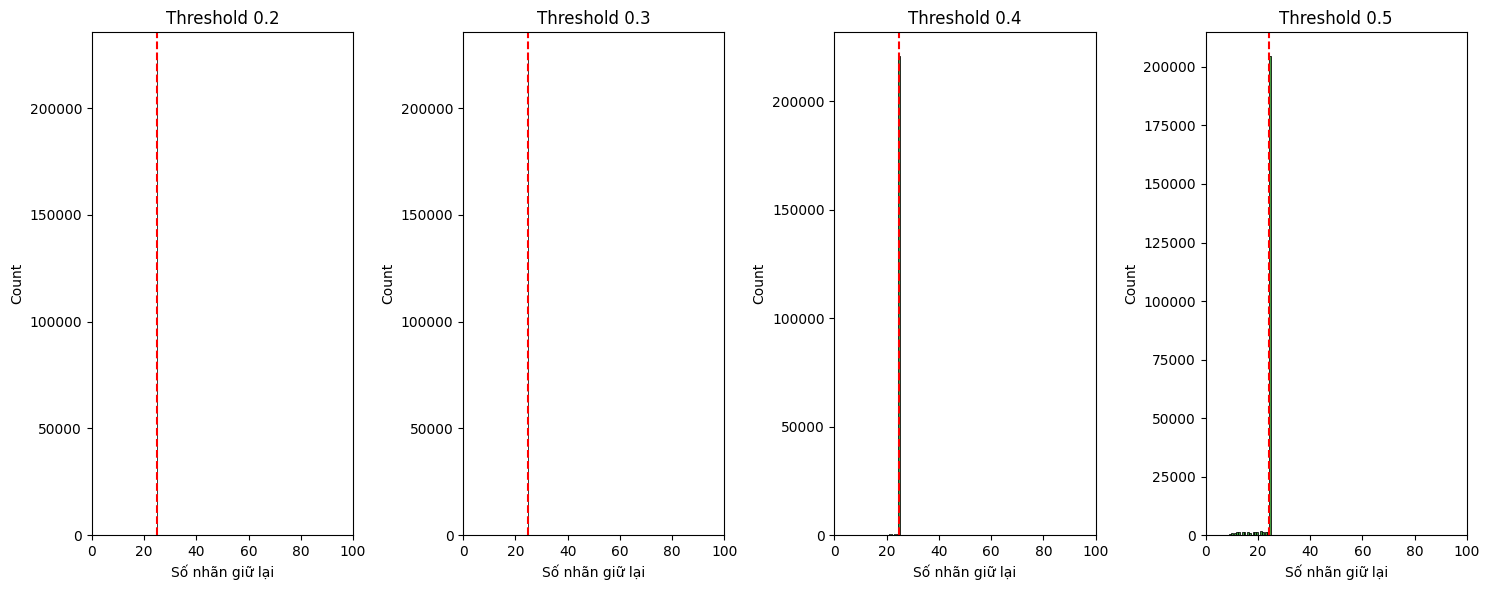

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==============================================================================
# 1. CẤU HÌNH
# ==============================================================================
FILE_PATH = '/content/drive/MyDrive/CAFA6_Results/prott5_esm2_ankh_ASL_Run/submission.tsv'

print("⏳ Đang đọc file submission (Có thể tốn RAM nếu file lớn)...")
# Đọc file, đặt tên cột chuẩn
df = pd.read_csv(FILE_PATH, sep='\t', header=None, names=['id', 'term', 'score'])
print(f"✅ Đã tải {len(df):,} dòng dự đoán.")

# ==============================================================================
# 2. PHÂN TÍCH PHÂN PHỐI ĐIỂM SỐ (SCORE DISTRIBUTION)
# ==============================================================================
def analyze_scores(df):
    print("\n" + "="*60)
    print("📊 PHÂN TÍCH 1: PHÂN PHỐI ĐIỂM SỐ (CONFIDENCE)")
    print("="*60)

    # Thống kê cơ bản
    stats = df['score'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95])
    print(stats)

    # Vẽ biểu đồ Histogram
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df['score'], bins=100, kde=True, color='purple')
    plt.title('Phân phối Điểm số (Toàn bộ)')
    plt.xlabel('Score')
    plt.ylabel('Số lượng')
    plt.axvline(stats['50%'], color='red', linestyle='--', label=f'Median: {stats["50%"]:.3f}')
    plt.legend()

    # Vẽ biểu đồ Log Scale để xem phần đuôi (Tail)
    plt.subplot(1, 2, 2)
    sns.histplot(df['score'], bins=100, log_scale=(False, True), color='blue')
    plt.title('Phân phối Điểm số (Log Scale - Để soi nhiễu)')
    plt.xlabel('Score')
    plt.ylabel('Log Count')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ==============================================================================
# 3. PHÂN TÍCH SỐ LƯỢNG DỰ ĐOÁN (TOP-K SIMULATION)
# ==============================================================================
def simulate_top_k(df, thresholds=[0.2, 0.3, 0.4, 0.5]):
    print("\n" + "="*60)
    print("🎯 PHÂN TÍCH 2: GIẢ LẬP SỐ LƯỢNG NHÃN (TOP-K)")
    print("="*60)
    print("Nếu chọn Threshold X, thì trung bình mỗi Protein giữ lại bao nhiêu nhãn?")

    plt.figure(figsize=(15, 6))

    for i, thresh in enumerate(thresholds):
        # Lọc dữ liệu theo ngưỡng giả định
        subset = df[df['score'] >= thresh]

        # Đếm số nhãn trên mỗi protein
        counts = subset.groupby('id').size()

        # In thống kê nhanh
        print(f"\n🔹 Với Threshold >= {thresh}:")
        print(f"   - Số protein còn lại: {len(counts):,}")
        print(f"   - Trung bình nhãn/protein: {counts.mean():.1f}")
        print(f"   - 95% protein có ít hơn: {counts.quantile(0.95):.0f} nhãn")
        print(f"   - Max nhãn/protein: {counts.max()}")

        # Vẽ Density Plot
        plt.subplot(1, len(thresholds), i+1)
        sns.histplot(counts, bins=30, kde=False, color='green')
        plt.title(f'Threshold {thresh}')
        plt.xlabel('Số nhãn giữ lại')
        plt.xlim(0, 100) # Giới hạn trục X để dễ nhìn
        plt.axvline(counts.mean(), color='red', linestyle='--')

    plt.tight_layout()
    plt.show()

# ==============================================================================
# CHẠY PHÂN TÍCH
# ==============================================================================
analyze_scores(df)
simulate_top_k(df, thresholds=[0.2, 0.3, 0.4, 0.5])